# Intro
Benchmarking the performance of merges. 

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import timeit

In [2]:
pandas.__version__, numpy.__version__

('0.25.3', '1.17.3')

In [3]:
def generate_dataframes(N:int, set_index: bool, type_def: str, duplicates:float):
    
    numpy.random.seed(11)
    if duplicates >0:
        sample = int((1-duplicates)*N)+1
        array_1 = numpy.random.choice(sample, N, replace=True)
    else:
        array_1 = numpy.arange(N)
        numpy.random.shuffle(array_1) # shuffle works in-place
        
    df_1 = pandas.DataFrame(array_1, columns=["A"])
    df_1["B"] = df_1["A"]*2

    array_2 = array_1.copy()
    numpy.random.shuffle(array_2)
    df_2 = pandas.DataFrame(array_2, columns=["A"])
    df_2["B"] = df_2["A"]*2
    
    if type_def == "datetime":
        df_1["A"] = pandas.to_datetime(df_1["A"])
        df_2["A"] = pandas.to_datetime(df_2["A"])
    else:
        df_1["A"] =df_1["A"].astype(type_def)
        df_2["A"] =df_2["A"].astype(type_def)
    
    if set_index:
        df_1 = df_1.set_index("A")
        df_2 = df_2.set_index("A")
    
    return df_1, df_2

def get_time(df_1: pandas.DataFrame, df_2: pandas.DataFrame, indexed: bool):
    if indexed:
        time_result = %timeit -o df_1.merge(df_2, how="left", left_index=True, right_index=True)
    else:
        time_result = %timeit -o df_1.merge(df_2, how="left", left_on="A", right_on="A")
    return time_result.average

def profile(df_1: pandas.DataFrame, df_2: pandas.DataFrame, indexed: bool):
    if indexed:
        df_1.merge(df_2, how="left", left_index=True, right_index=True)
    else:
        df_1.merge(df_2, how="left", left_on="A", right_on="A")

In [4]:
#1. Compare performance of merge for various sizes when joining on index vs not on index
sizes = [1,10,100,1_000, 10_000, 100_000, 1_000_000, 10_000_000, 100_000_000] 

dfs = [generate_dataframes(N, False, "int", duplicates=0) for N in sizes]
time_by_size = [get_time(df_1, df_2, False) for (df_1, df_2) in dfs]

dfs_indexed = [generate_dataframes(N, True, "int", duplicates=0) for N in sizes]
time_by_size_indexed = [get_time(df_1, df_2, True) for (df_1, df_2) in dfs_indexed]

1.78 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.85 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.77 ms ± 38.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.92 ms ± 37.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.07 ms ± 23.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
28.6 ms ± 420 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
504 ms ± 5.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.98 s ± 113 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 28s ± 2.99 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
430 µs ± 3.94 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
534 µs ± 8.34 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
532 µs ± 3.14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
564 µs ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
708 µs ± 35.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.46 

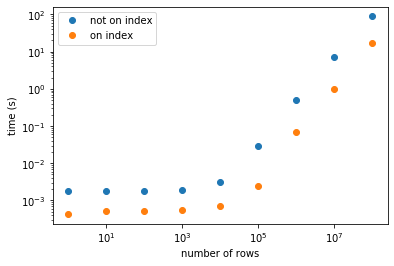

In [5]:
# plot results
fig, ax = plt.subplots()
ax.plot(sizes, time_by_size, 'o', label="not on index")
ax.plot(sizes, time_by_size_indexed, 'o', label="on index")
ax.set_xlabel("number of rows")
ax.set_ylabel("time (s)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
fig.savefig("merge-performance-by-size.png")
fig.savefig("merge-performance-by-size.svg")

In [6]:
#2. Compare performance of merging on different dtypes (on index vs not on index)
type_defs = ["datetime", pandas.Int64Dtype(), "int", "str", "category", "float"]
dfs = [generate_dataframes(1_000_000, False, type_def, duplicates=0) for type_def in type_defs]
time_by_type = [get_time(df_1, df_2, False) for (df_1, df_2) in dfs]

dfs = [generate_dataframes(1_000_000, True, type_def, duplicates=0) for type_def in type_defs]
time_by_type_indexed = [get_time(df_1, df_2, True) for (df_1, df_2) in dfs]
type_defs = ["datetime", "nullable-int", "int", "str", "category", "float"]

508 ms ± 4.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
850 ms ± 20 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
499 ms ± 3.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.2 s ± 24.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
652 ms ± 32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
998 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
58.2 ms ± 556 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
223 ms ± 4.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
70.5 ms ± 644 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
336 ms ± 2.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.28 s ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
82.8 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


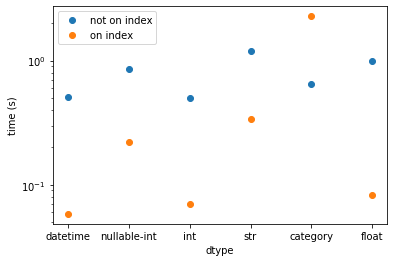

In [8]:
fig, ax = plt.subplots()
ax.plot(type_defs, time_by_type, 'o', label="not on index")
ax.plot(type_defs, time_by_type_indexed, 'o', label="on index")
ax.set_xlabel("dtype")
ax.set_ylabel("time (s)")
ax.set_yscale("log")
ax.legend()
fig.savefig("merge-performance-by-type.png")
fig.savefig("merge-performance-by-type.svg")

In [9]:
#3. performance depending on duplicate amount (proportion)
duplicates = [0,0.05, 0.1, 0.2,0.4,0.6, 0.8, 0.9, 0.95]

dfs = [generate_dataframes(1_000_000, False, "int", duplicates=d) for d in duplicates]
time_by_duplicates = [get_time(df_1, df_2, False) for (df_1, df_2) in dfs]

dfs_indexed = [generate_dataframes(1_000_000, True, "int", duplicates=d) for d in duplicates]
time_by_duplicates_indexed = [get_time(df_1, df_2, True) for (df_1, df_2) in dfs_indexed]

514 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
583 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
600 ms ± 22.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
611 ms ± 15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
583 ms ± 8.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
663 ms ± 15.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
940 ms ± 99.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.39 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.28 s ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
70.8 ms ± 3.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
965 ms ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
999 ms ± 95.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
976 ms ± 76.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
953 ms ± 43.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
789 ms ± 83.1 ms per loop (mean ± std. dev. of 7 r

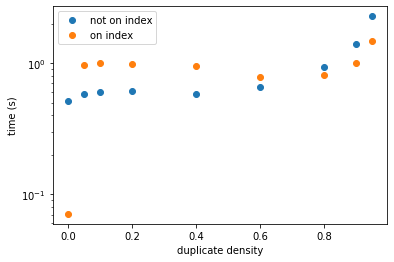

In [21]:
fig, ax = plt.subplots()
ax.plot(duplicates, time_by_duplicates, 'o', label="not on index")
ax.plot(duplicates, time_by_duplicates_indexed, 'o', label="on index")
ax.set_xlabel("duplicate density")
ax.set_ylabel("time (s)")
ax.set_yscale("log")
ax.legend()
fig.savefig("merge-performance-by-duplicate.png")
fig.savefig("merge-performance-by-duplicate.svg")

In [15]:
#4. Sorted vs unsorted
# (unsorted)
df_1, df_2 = generate_dataframes(1_000_000, True, "int", duplicates=0)
get_time(df_1, df_2, True)

66.8 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


0.06684142000001105

In [16]:
# sorted dfs merge much faster...
df_1, df_2 = generate_dataframes(1_000_000, True, "int", duplicates=0)
df_1 = df_1.sort_values("A", ascending=True)
df_2 = df_2.sort_values("A", ascending=True)
get_time(df_1, df_2, True)

7.02 ms ± 343 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


0.007017911428570838

In [17]:
df_1, df_2 = generate_dataframes(1_000_000, True, "int", duplicates=0)
df_1 = df_1.sort_values("A", ascending=True)
get_time(df_1, df_2, True)

44.9 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


0.04490464285714292

In [18]:
sizes = [1,10,100,1_000, 10_000, 100_000, 1_000_000, 10_000_000] 

dfs = [generate_dataframes(N, False, "int", duplicates=0) for N in sizes]
time_by_size = [get_time(df_1, df_2, False) for (df_1, df_2) in dfs]

dfs_sorted = [(df_1.copy().sort_values("A", ascending=True),
               df_2.copy().sort_values("A", ascending=True)) for (df_1, df_2) in dfs]
time_by_size_sorted = [get_time(df_1, df_2, False) for (df_1, df_2) in dfs_sorted]

dfs_indexed = [generate_dataframes(N, True, "int", duplicates=0) for N in sizes]
time_by_size_indexed = [get_time(df_1, df_2, True) for (df_1, df_2) in dfs_indexed]

dfs_indexed_sorted = [(df_1.copy().sort_values("A", ascending=True),
                       df_2.copy().sort_values("A", ascending=True)) for (df_1, df_2) in dfs_indexed]
time_by_size_indexed_sorted = [get_time(df_1, df_2, True) for (df_1, df_2) in dfs_indexed_sorted]

1.83 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.97 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.94 ms ± 35.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.99 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.22 ms ± 84.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
35.4 ms ± 8.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
545 ms ± 29.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.71 s ± 552 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.76 ms ± 84.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.78 ms ± 72.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.95 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.03 ms ± 294 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.88 ms ± 54.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
27.8 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
414

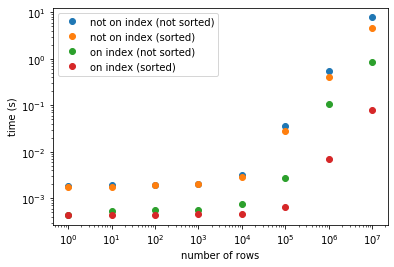

In [23]:
fig, ax = plt.subplots()
ax.plot(sizes, time_by_size, 'o', label="not on index (not sorted)")
ax.plot(sizes, time_by_size_sorted, 'o', label="not on index (sorted)")
ax.plot(sizes, time_by_size_indexed, 'o', label="on index (not sorted)")
ax.plot(sizes, time_by_size_indexed_sorted, 'o', label="on index (sorted)")
ax.set_xlabel("number of rows")
ax.set_ylabel("time (s)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
fig.savefig("merge-performance-by-size-sorting.png")
fig.savefig("merge-performance-by-size-sorting.svg")

In [ ]:
# map vs merge - for small mapping tables using map is faster than join
df_1, df_2 = generate_dataframes(1_000_000, False, "int", duplicates=0.999)
df_3 = pandas.DataFrame([x for x in range(df_1["A"].max()+1)], columns=["A"])
df_3["B"]=[x*2 for x in range(df_1["A"].max()+1)]
mapping ={x:x*2 for x in range(df_1["A"].max()+1)}

In [ ]:
get_time(df_1, df_3, False)

In [ ]:
%timeit df_1["A"].map(mapping)